0.4
computing velocities
    finished (0:00:00) --> added 
    'steady_state_velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/48 cores)


  0%|          | 0/3500 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'steady_state_velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 30/48 cores)


  0%|          | 0/1000 [00:00<?, ?gene/s]

    finished (0:01:27) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:10) --> added 
    'dynamical_velocity', velocity vectors for each individual cell (adata.layers)
0
100
200
300
400
500
600
700
800
900
running scv analysis
0.4
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


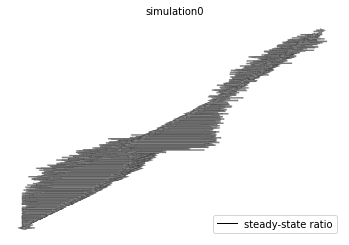

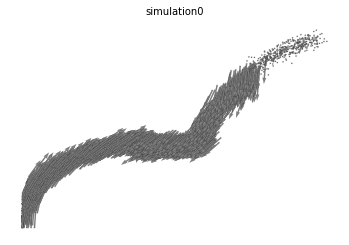

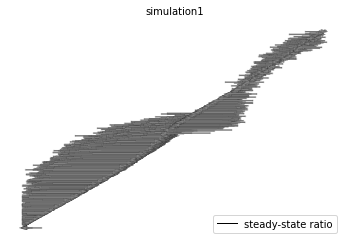

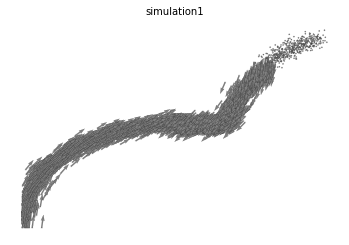

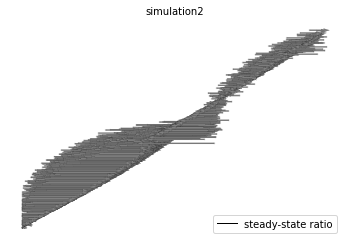

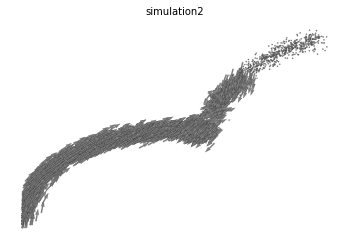

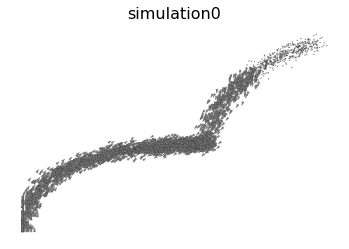

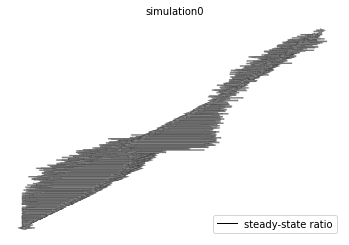

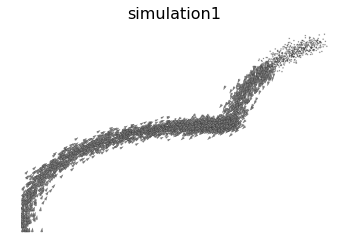

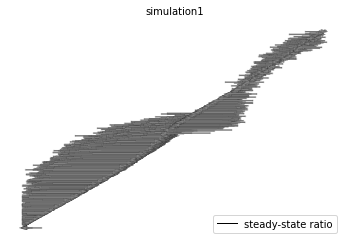

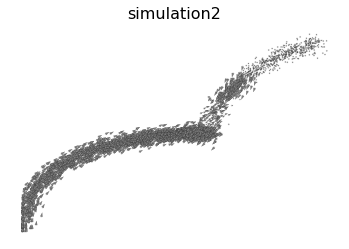

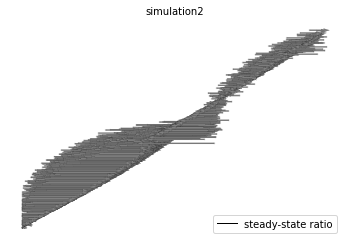

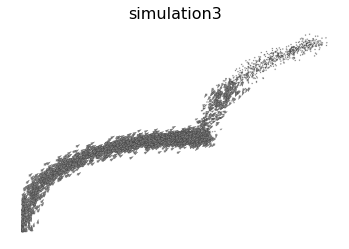

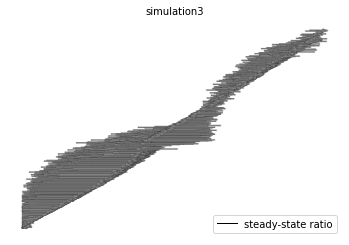

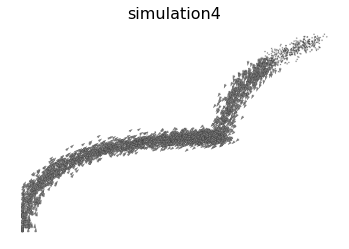

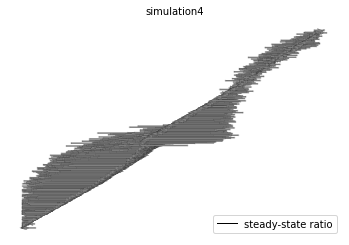

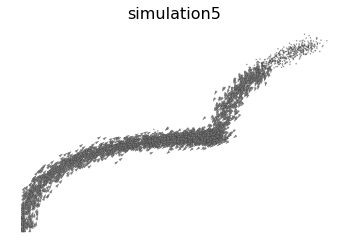

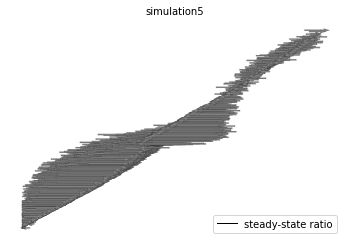

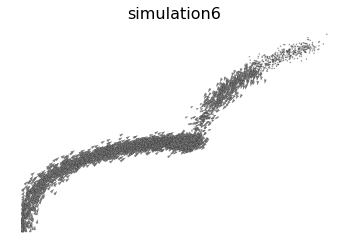

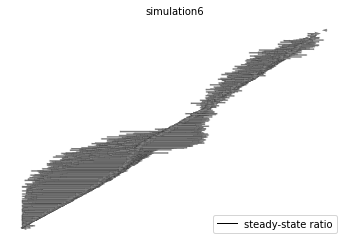

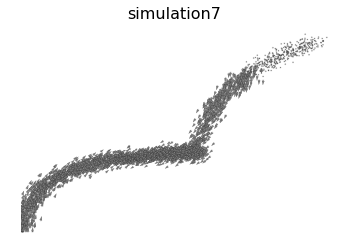

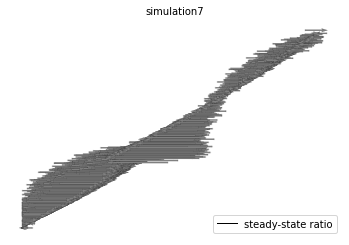

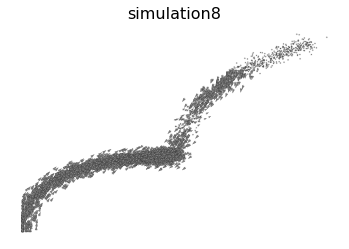

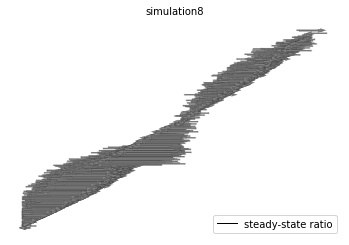

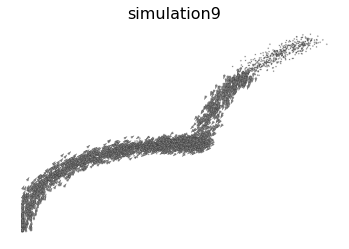

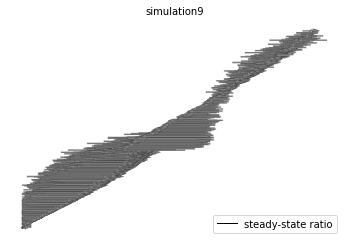

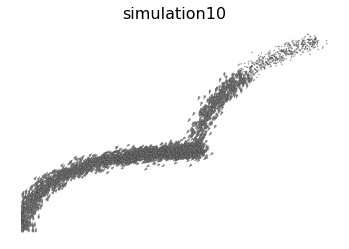

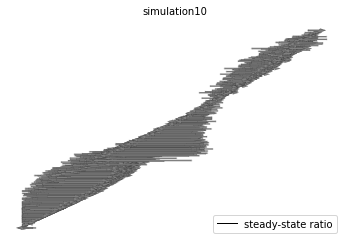

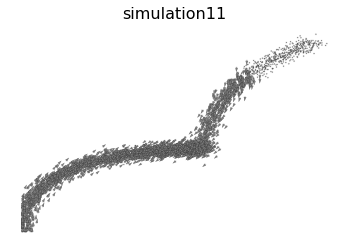

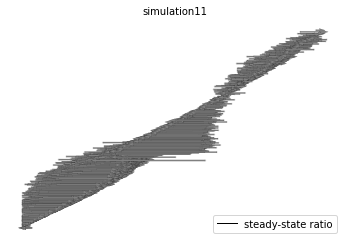

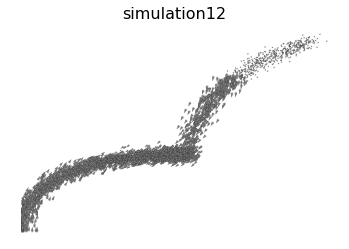

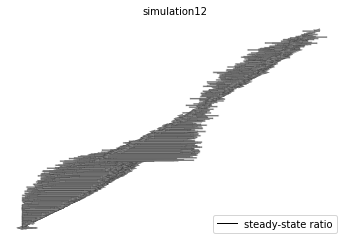

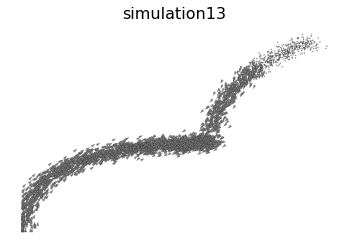

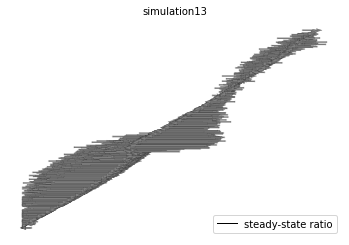

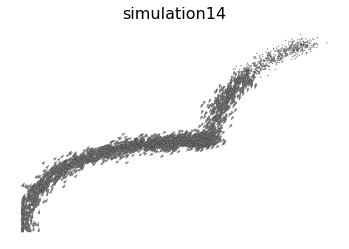

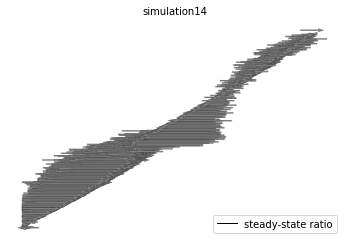

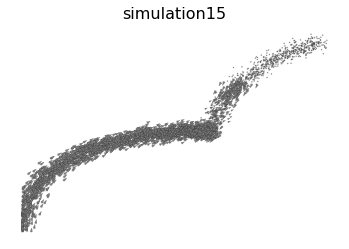

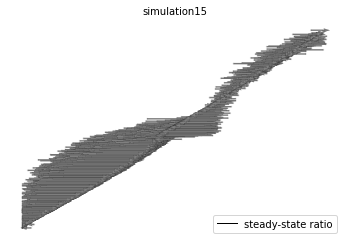

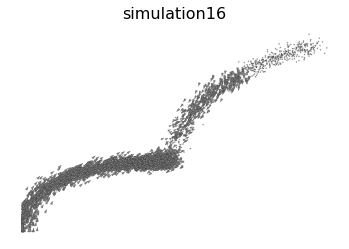

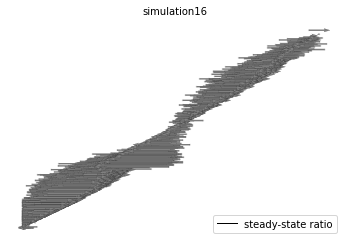

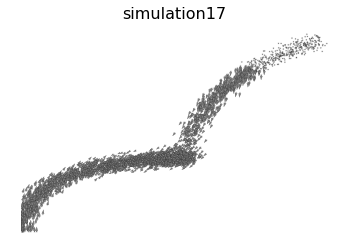

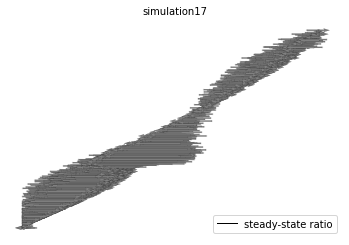

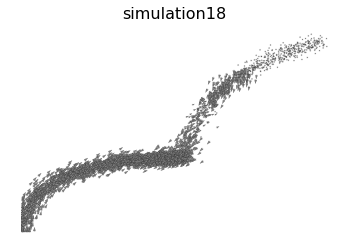

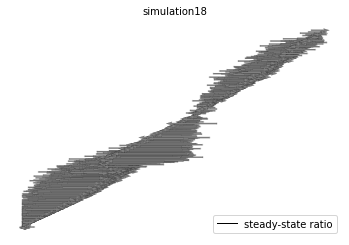

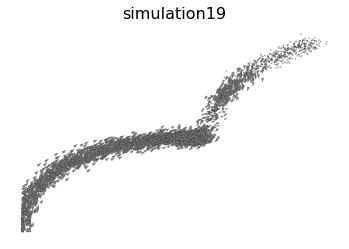

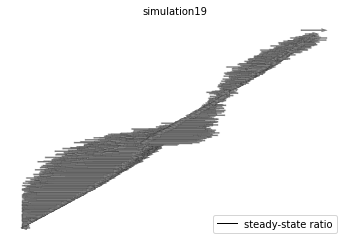

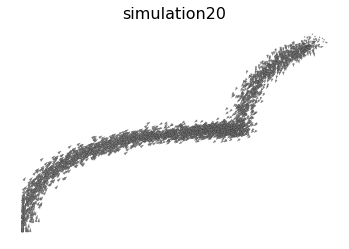

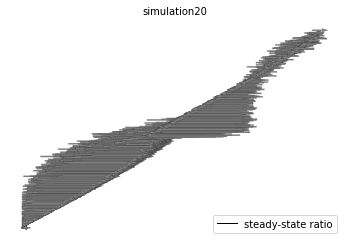

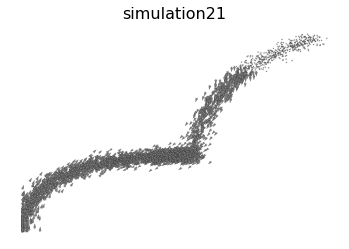

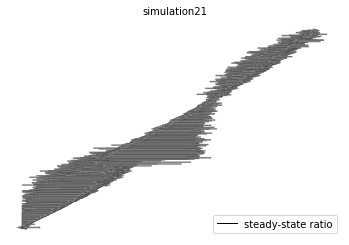

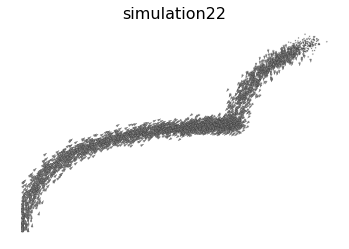

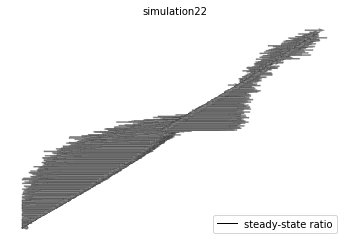

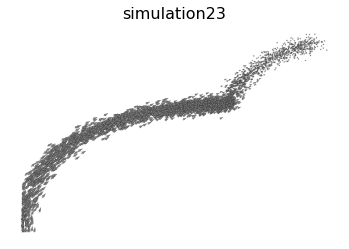

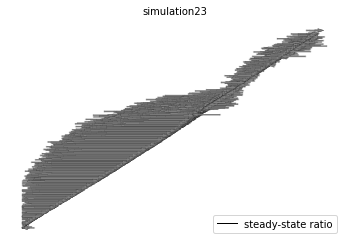

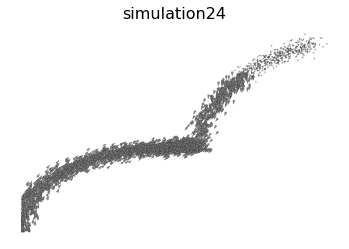

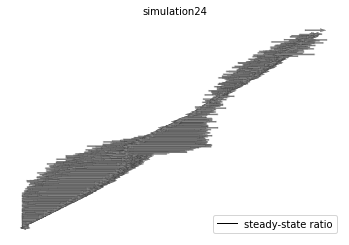

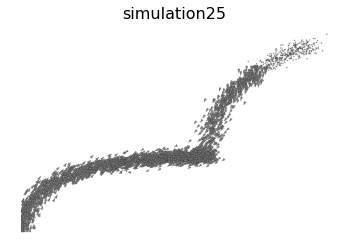

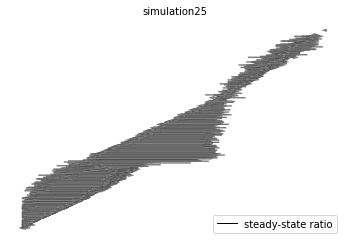

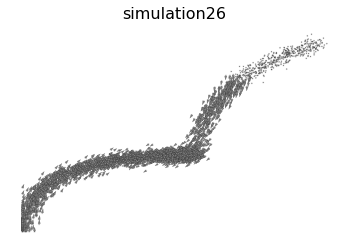

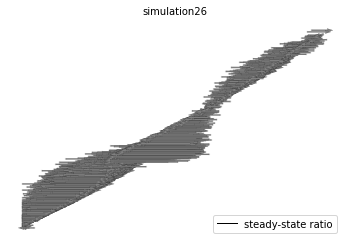

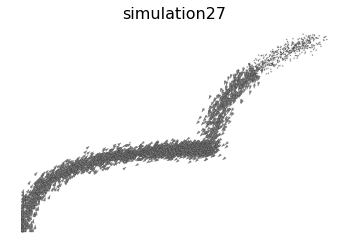

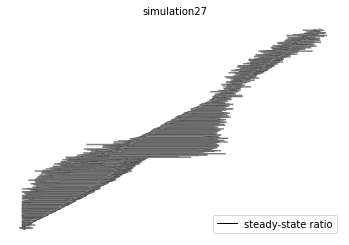

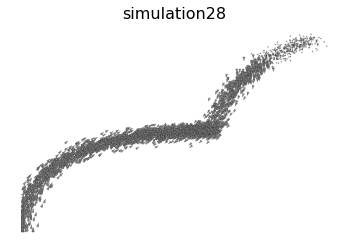

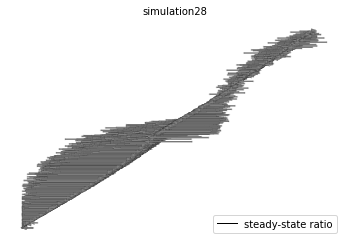

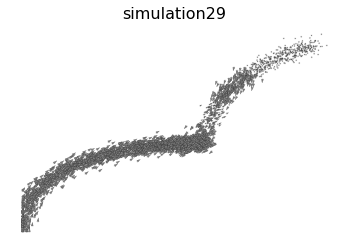

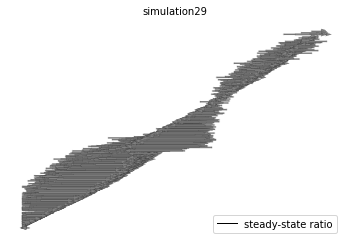

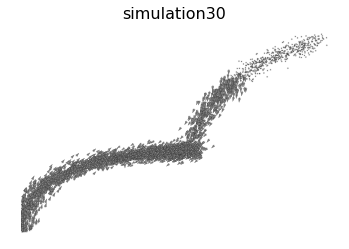

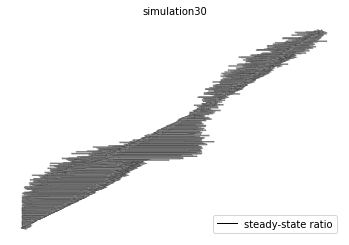

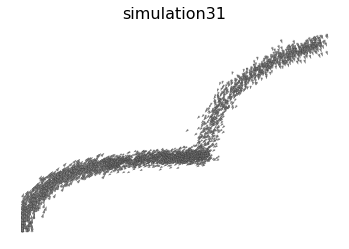

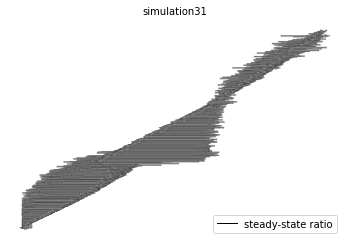

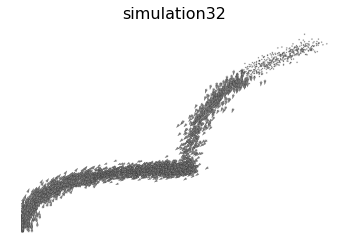

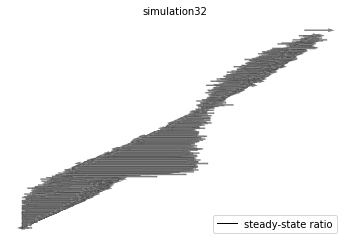

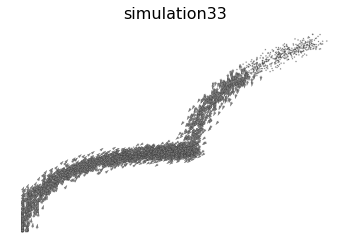

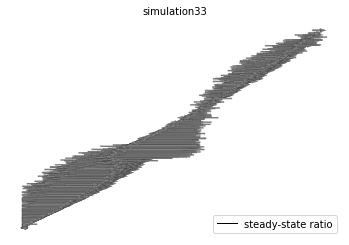

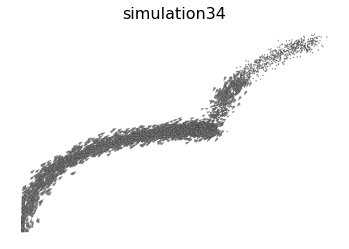

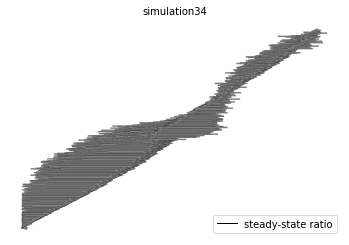

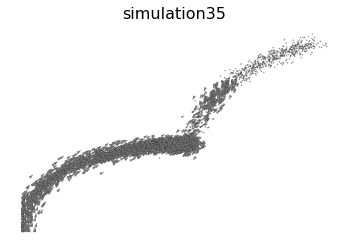

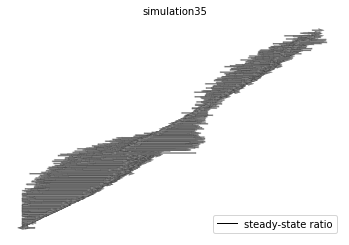

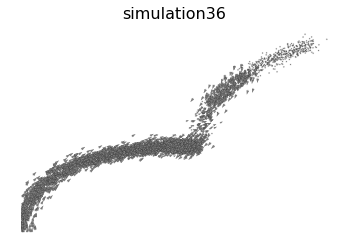

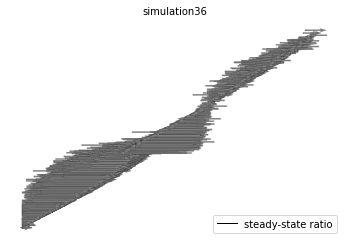

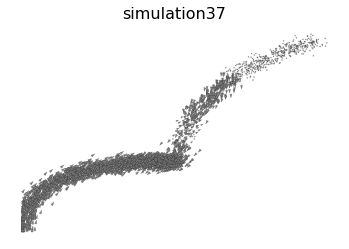

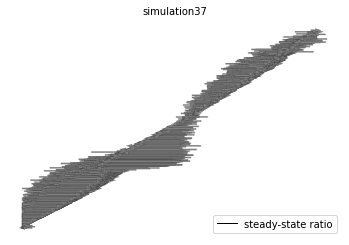

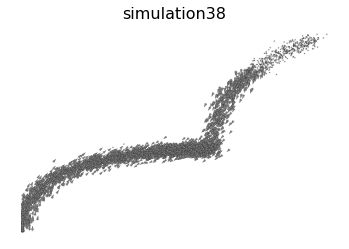

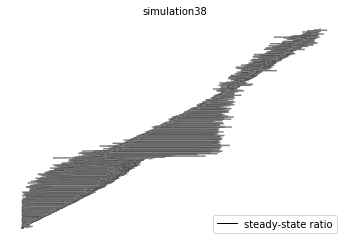

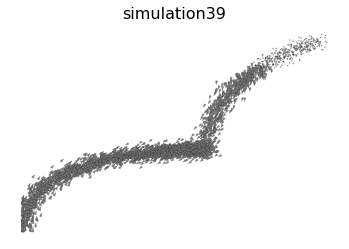

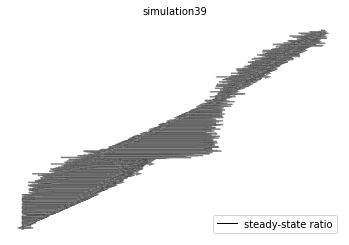

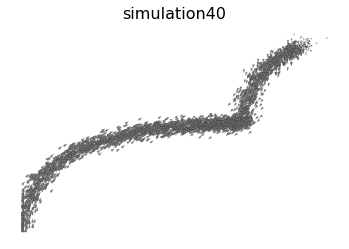

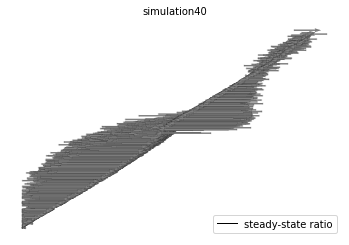

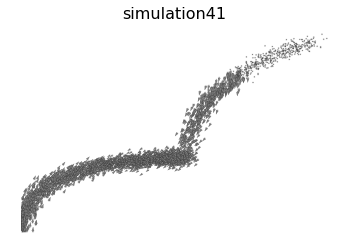

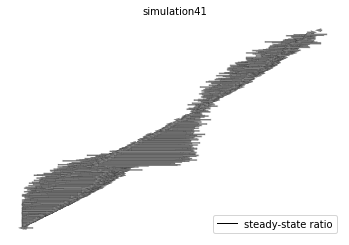

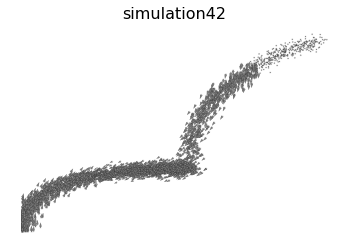

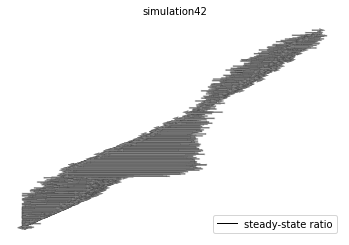

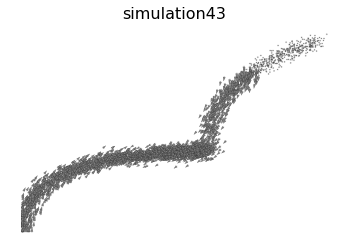

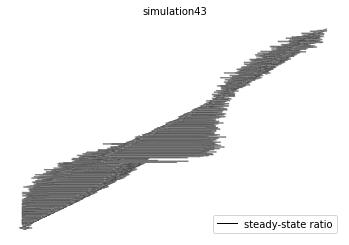

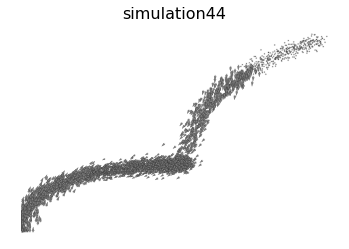

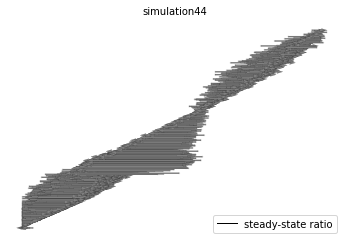

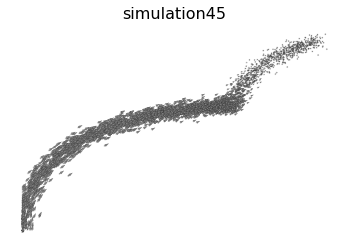

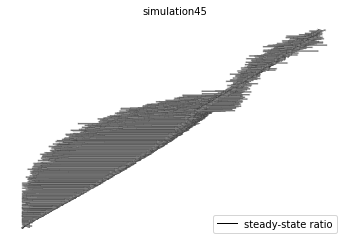

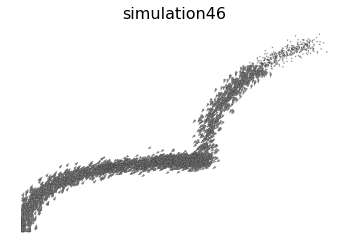

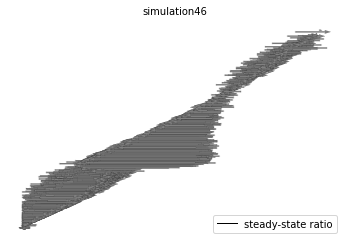

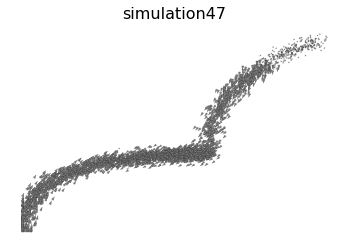

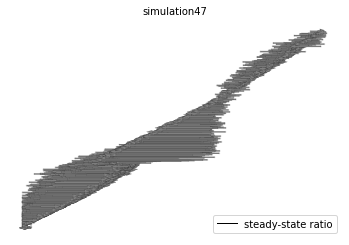

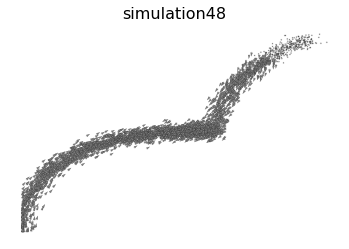

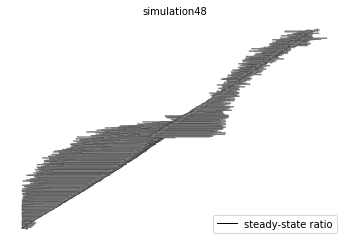

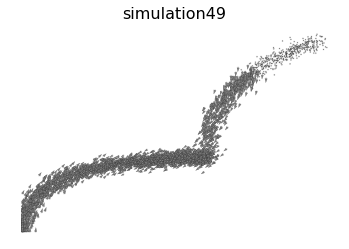

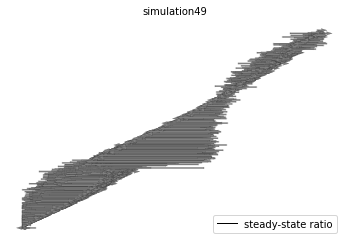

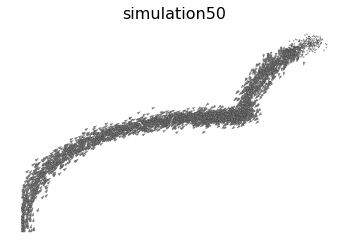

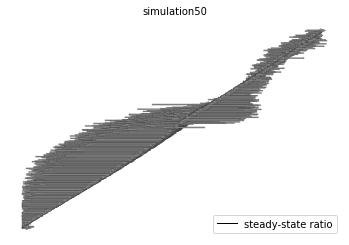

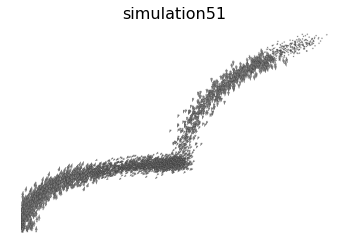

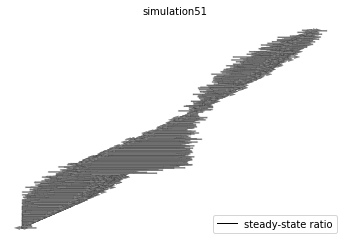

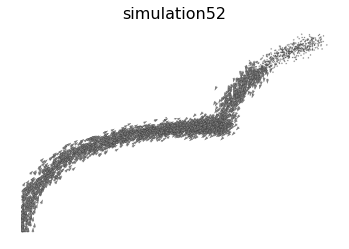

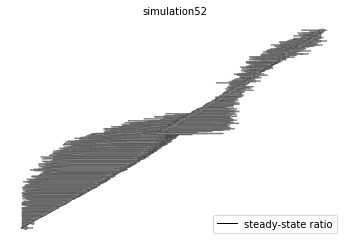

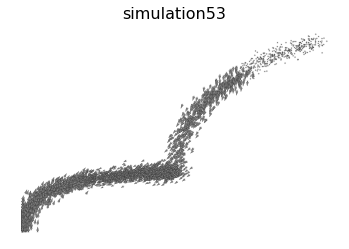

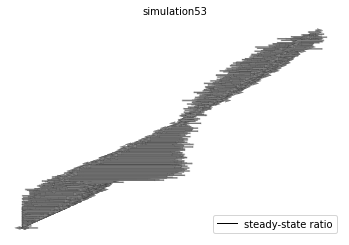

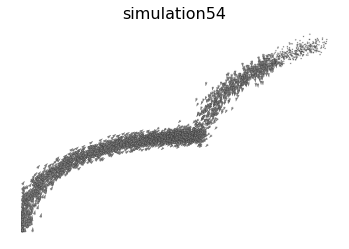

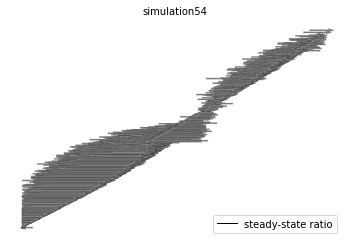

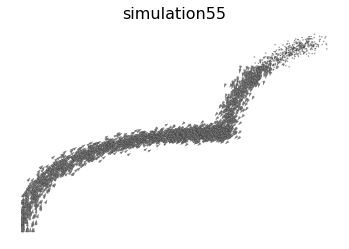

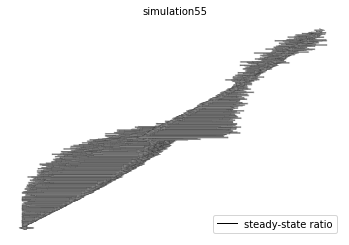

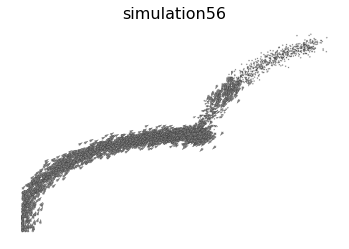

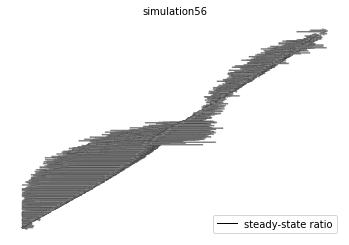

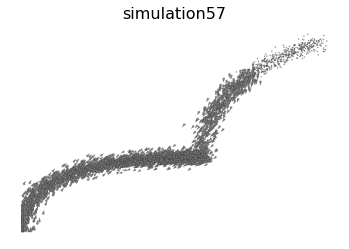

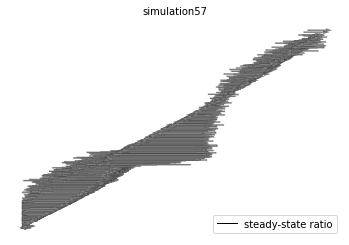

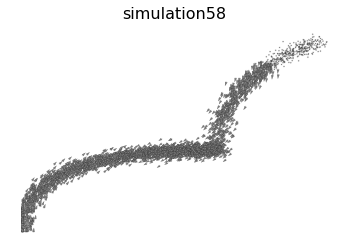

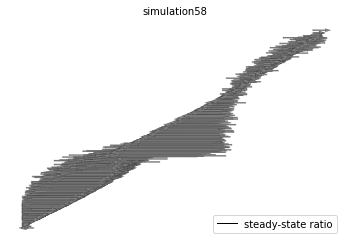

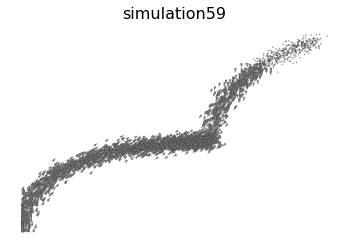

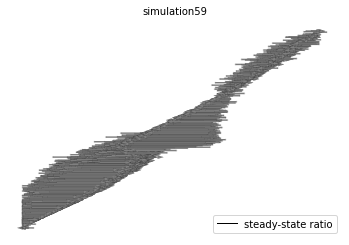

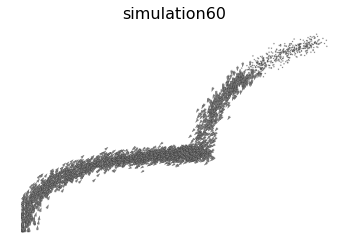

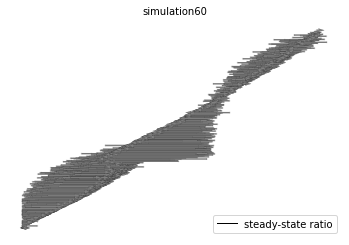

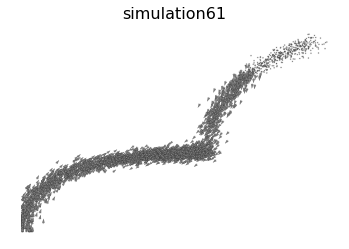

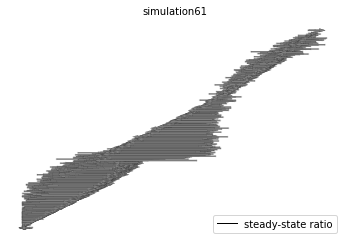

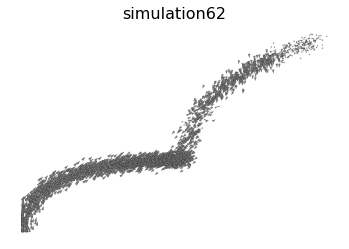

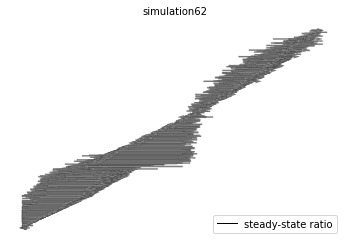

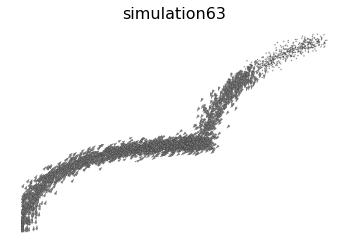

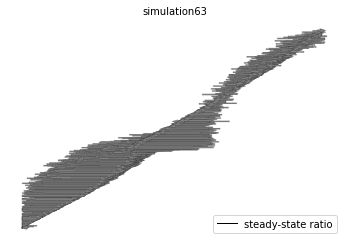

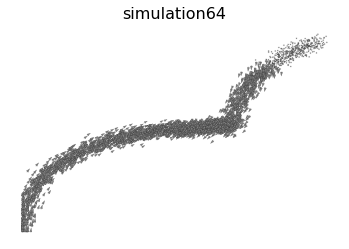

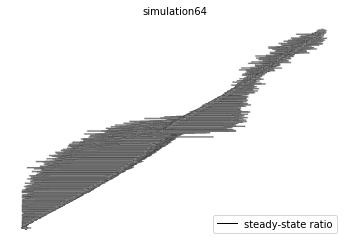

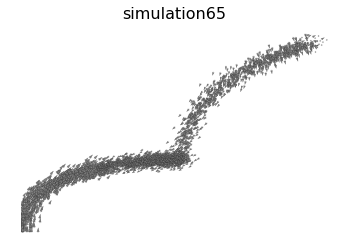

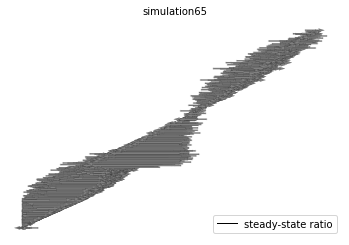

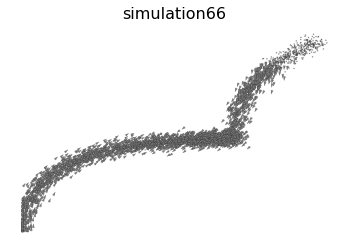

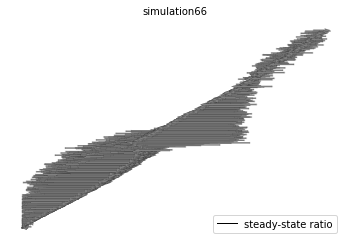

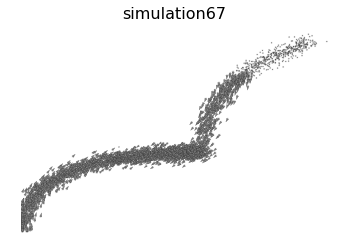

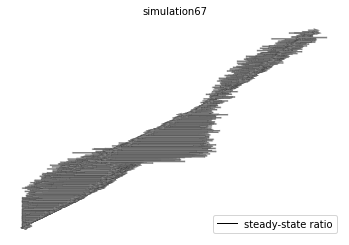

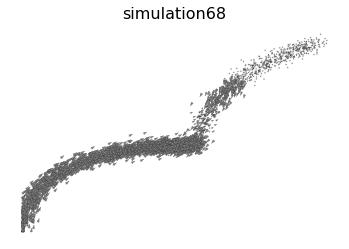

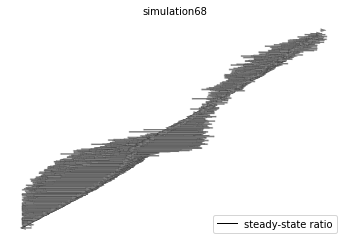

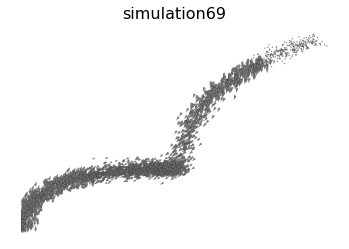

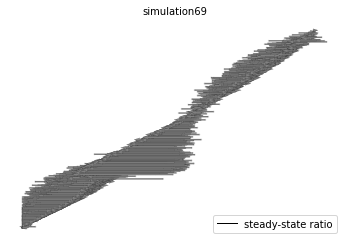

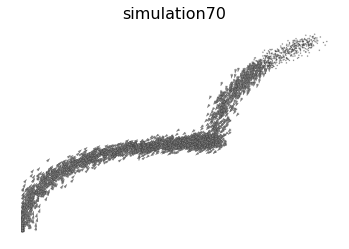

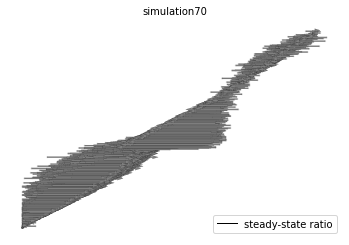

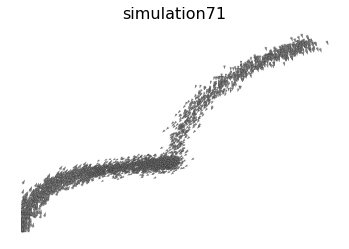

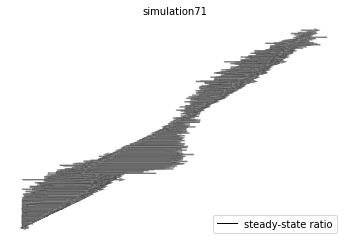

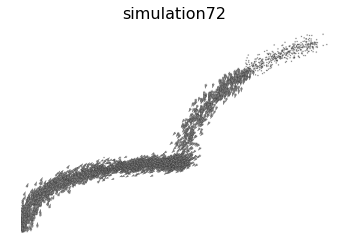

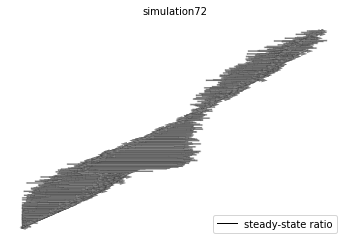

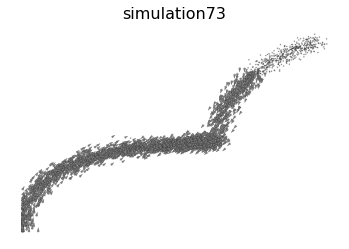

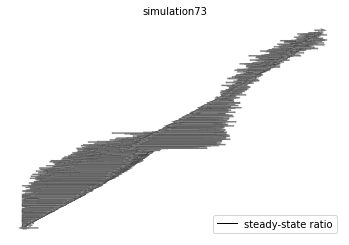

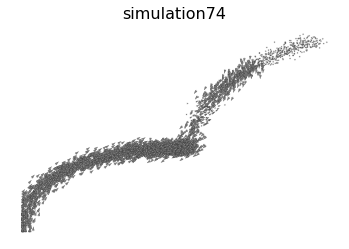

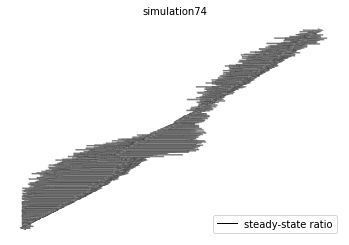

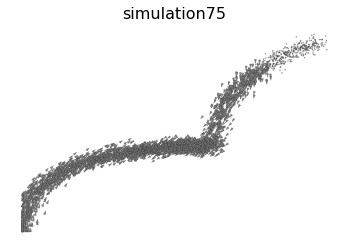

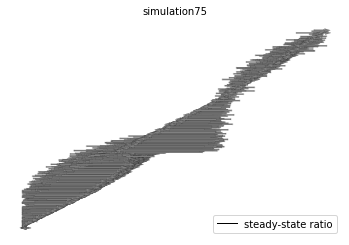

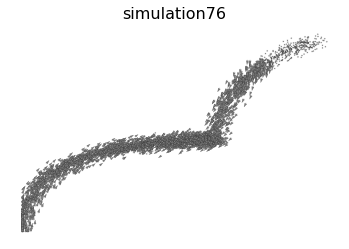

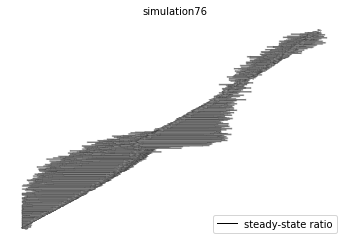

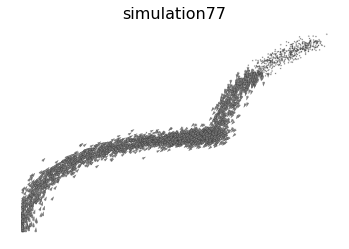

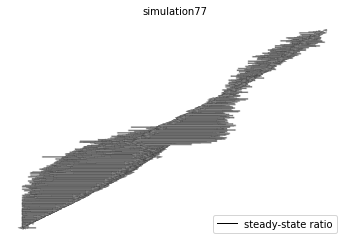

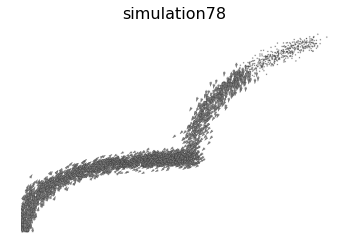

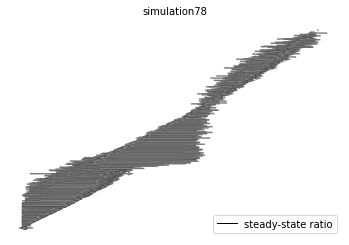

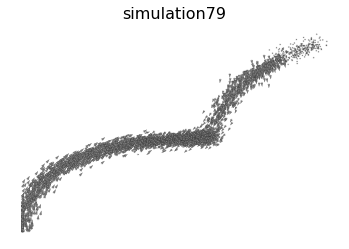

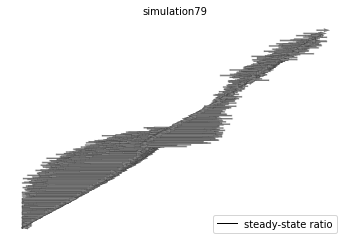

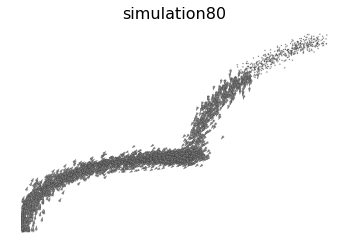

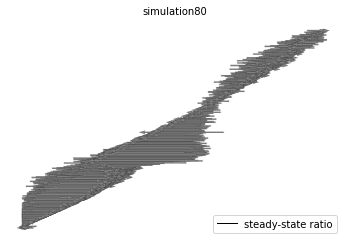

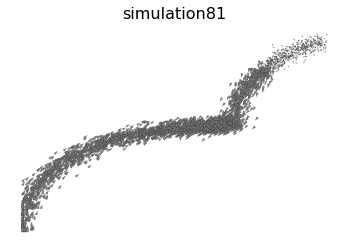

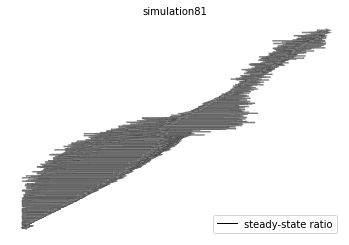

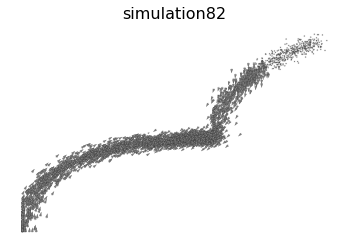

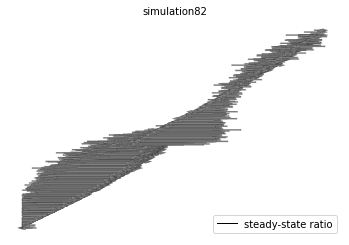

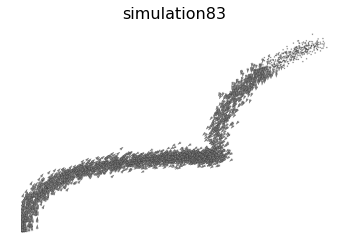

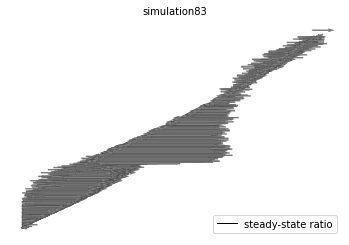

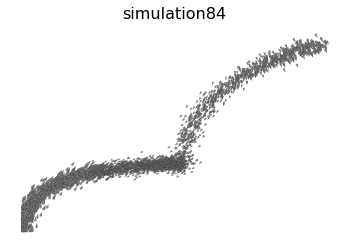

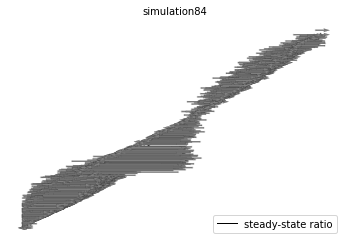

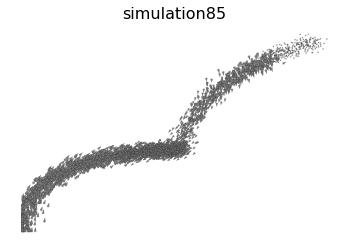

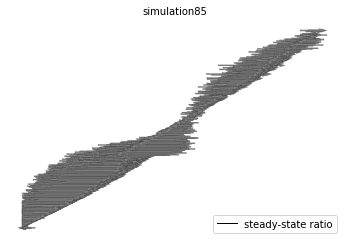

Error in callback <function flush_figures at 0x7ff2e87453b0> (for post_execute):


KeyboardInterrupt: 

In [14]:
# modified form https://github.com/GuangyuWangLab2021/veloNN/blob/main/tests/scanpy_th9_velocyto.py
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import anndata
srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
sys.path.append(srcdir)
from celldancer.sampling import sampling_neighbors
from celldancer.cdplt import colormap
import celldancer.cdplt as cdplt
import os
import math

# %%capture
# Load the data

def pipline_run_sim_data(load_raw_data,name,ratio):

    # unsplice&splice
    splice_mat=load_raw_data.pivot(index='gene_name', values='splice', columns='cellID')
    unsplice_mat=load_raw_data.pivot(index='gene_name', values='unsplice', columns='cellID')

    one_gene_raw=load_raw_data[load_raw_data.gene_name==load_raw_data.gene_name[0]]

    cols=one_gene_raw['cellID']
    splice_mat = splice_mat[cols].T
    unsplice_mat = unsplice_mat[cols].T
    splice_mat.to_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/splice_'+ratio+'.csv')
    unsplice_mat.to_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/unsplice_'+ratio+'.csv')

    splice_mat=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/splice_'+ratio+'.csv')
    unsplice_mat=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/unsplice_'+ratio+'.csv')

    adata_building=sc.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/splice_'+ratio+'.csv', delimiter=',', first_column_names=True, dtype='float32')
    adata_building.layers['Ms']=splice_mat.to_numpy()[:,1:]
    adata_building.layers['Mu']=unsplice_mat.to_numpy()[:,1:]

    adata_building.layers['Ms']=np.array(adata_building.layers['Ms'], dtype=float)
    adata_building.layers['Mu']=np.array(adata_building.layers['Mu'], dtype=float)

    adata_building_test=adata_building.copy()
    # adata_building_test2=adata_building.copy()

    # velocity
    # scv.pp.moments(adata_building_test, n_pcs=30, n_neighbors=30)
    # scv.pp.moments(adata_building_test, n_pcs=50, n_neighbors=50)

    # steady_state_velocity
    scv.tl.velocity(adata_building_test, vkey='steady_state_velocity', mode='steady_state')
    scv.tl.velocity_graph(adata_building_test, vkey='steady_state_velocity')

    # dynamical_velocity
    scv.tl.recover_dynamics(adata_building_test, n_jobs=30, n_top_genes = 1000)
    scv.tl.velocity(adata_building_test, vkey='dynamical_velocity',mode='dynamical',filter_genes=False)
    
    # plot - steady_state_velocity
    gene_choice=load_raw_data['gene_name'].drop_duplicates()

    for gene in list(gene_choice)[0:3]:
        scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                            scale=.6, width=.0035, frameon=False, title=gene,show=False)
        # plot- dynamical_velocity
        scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene, scale=4, width=.0035,
                            frameon=False, title=gene,show=False)
        
    adata_building_test.write(filename='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/build_scv_compatible_raw/backpath_'+ratio+'.h5ad')

    # gene velocity plot
    gene_choice=load_raw_data['gene_name'].drop_duplicates()
    # gene_choice=['simulation0','simulation1']

    outpath='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/scv'
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df=pd.DataFrame()
    for nth,gene in enumerate(gene_choice):
        if nth % 100 ==0: print(nth)
        # dynamical_velocity
        outpath='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/scv'
        save_path=os.path.join(outpath,'scvelo_result',('wing_path_'),(gene+'_dynamic.pdf'))
        X, V=scv.pl.velocity_embedding(adata_building_test, vkey='dynamical_velocity', basis=gene,
                            fontsize=16, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict=np.concatenate((X, V), axis=1)

        # steady_state_velocity
        save_path=os.path.join(outpath,'scvelo_result',('wing_path_'),(gene+'_static.pdf'))
        X_steady, V_steady=scv.pl.velocity_embedding(adata_building_test, vkey='steady_state_velocity', basis=gene,
                          scale=.6, width=.0035, frameon=False,show=False)
        splice_unsplice_splice_predict_unsplice_predict_steady=np.concatenate((X_steady, V_steady), axis=1)

        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady=np.hstack((splice_unsplice_splice_predict_unsplice_predict,splice_unsplice_splice_predict_unsplice_predict_steady))
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.DataFrame(one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady, columns = ['dynamic_splice','dynamic_unsplice','dynamic_splice_predict','dynamic_unsplice_predict','static_splice','static_unsplice','static_splice_predict','static_unsplice_predict'])
        one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.insert (0, "gene_name", gene)
        gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df = pd.concat([gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df,one_gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df])
        
    gene_splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df.to_csv(os.path.join(outpath,'scvelo_result_wing_path__splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df_'+ratio+'.csv'),index=False)


    #
if __name__ == "__main__":
    # raw_data_path='/Users/shengyuli/OneDrive - Houston Methodist/work/Velocity/data/velocyto/neuro/raw_data/denGyr_full_two_genes.csv'
    # load_raw_data=pd.read_csv(raw_data_path,names=['gene_name', 'unsplice','splice',"clusters",'cellID','embedding1','embedding2'])

    # load_raw_data_twogenes=load_raw_data[load_raw_data.gene_name.isin(['Rgs20','Gpm6b'])]
    # load_raw_data_twogenes.to_csv('/Users/shengyuli/OneDrive - Houston Methodist/work/Velocity/data/velocyto/neuro/raw_data/denGyr_full_two_genes.csv',index=False, header=True)
    # load_raw_data=pd.read_csv('/Users/shengyuli/OneDrive - Houston Methodist/work/Velocity/data/velocyto/neuro/raw_data/denGyr_full_two_genes.csv')
    ratio_list=[0.4,0.6,0.8,1]

    ratio_list=[0.4]

    for ratio in ratio_list:
        print(ratio)
        ratio=str(ratio)
        load_raw_data=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/raw/wing_path_Path2Upper_1000__R'+ratio+'.csv')
        gene_list=list(load_raw_data.gene_name.drop_duplicates())
        load_raw_data=load_raw_data[load_raw_data.gene_name.isin(gene_list)]
        name='sim_wing_path'
        pipline_run_sim_data(load_raw_data,name,ratio)
        
        ############
        # analysis #
        ############
        from analysis_SIM_compare_fun_notebook import *
        import sys
        srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
        sys.path.append(srcdir)
        import celldancer.cdplt as cdplt

        ###############################################
        ########## cosin similarity analysis ##########
        ###############################################
        # path: server
        analysis_result_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/analysis_result/'
        detail_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/celldancer/'
        raw_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/raw/'
        scv_result_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/scv/'
        foldername_para=''

        ########## scv
        # path: server
        print('running scv analysis')
        # for ratio in [0.2,0.4,0.6,0.8,1]:
        print(ratio)
        scVelo = get_similarity_scVelo(ratio,scv_result_input_path,raw_input_path,type='wing',path='Path2Upper')
        scVelo.to_csv(analysis_result_path+'scvelo_similarity_eachCell'+str(ratio)+'.csv')
        sns.boxplot(x="ratio", y="similarity", hue='method', data=scVelo)

In [ ]:
############
# analysis #
############
from analysis_SIM_compare_fun_notebook import *
import sys
srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
sys.path.append(srcdir)
import celldancer.cdplt as cdplt

###############################################
########## cosin similarity analysis ##########
###############################################
# path: server
analysis_result_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/analysis_result/'
detail_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/celldancer/'
raw_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/raw/'
scv_result_input_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/scv/'
foldername_para=''

########## scv
# path: server
print('running scv analysis')
# for ratio in [0.2,0.4,0.6,0.8,1]:
print(ratio)
scVelo = get_similarity_scVelo(ratio,scv_result_input_path,raw_input_path,type='wing',path='Path2Upper')
scVelo.to_csv(analysis_result_path+'scvelo_similarity_eachCell'+str(ratio)+'.csv')
sns.boxplot(x="ratio", y="similarity", hue='method', data=scVelo)

# plot

In [11]:
import pandas as pd

scv_result=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/simulation/data0606_for_publication/wing_path/velocity_result/scv/scvelo_result_wing_path__splice_unsplice_splice_predict_unsplice_predict_dynamic_and_steady_df_0.4.csv')    

splice_unsplice_splice_predict_unsplice_predict_dynamic=scv_result[['gene_name','dynamic_splice','dynamic_unsplice','dynamic_splice_predict','dynamic_unsplice_predict']]
splice_unsplice_splice_predict_unsplice_predict_static=scv_result[['gene_name','static_splice','static_unsplice','static_splice_predict','static_unsplice_predict']]
splice_unsplice_splice_predict_unsplice_predict_dynamic=splice_unsplice_splice_predict_unsplice_predict_dynamic.rename(columns={'gene_name': 'gene_name', 'dynamic_splice': 'splice', 'dynamic_unsplice': 'unsplice', 'dynamic_splice_predict': 'splice_predict', 'dynamic_unsplice_predict': 'unsplice_predict'})
splice_unsplice_splice_predict_unsplice_predict_static=splice_unsplice_splice_predict_unsplice_predict_static.rename(columns={'gene_name': 'gene_name', 'static_splice': 'splice', 'static_unsplice': 'unsplice', 'static_splice_predict': 'splice_predict', 'static_unsplice_predict': 'unsplice_predict'})

splice_unsplice_splice_predict_unsplice_predict_dynamic.splice_predict=splice_unsplice_splice_predict_unsplice_predict_dynamic.splice+splice_unsplice_splice_predict_unsplice_predict_dynamic.splice_predict
splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice_predict=splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice+splice_unsplice_splice_predict_unsplice_predict_dynamic.unsplice_predict

splice_unsplice_splice_predict_unsplice_predict_static.splice_predict=splice_unsplice_splice_predict_unsplice_predict_static.splice+splice_unsplice_splice_predict_unsplice_predict_static.splice_predict
splice_unsplice_splice_predict_unsplice_predict_static.unsplice_predict=splice_unsplice_splice_predict_unsplice_predict_static.unsplice+splice_unsplice_splice_predict_unsplice_predict_static.unsplice_predict

In [16]:
splice_unsplice_splice_predict_unsplice_predict_dynamic

gene_name    splice  unsplice  splice_predict  unsplice_predict
0        simulation0  3.826160  1.049977        2.453425          1.049977
1        simulation0  3.756145  0.982693        2.360460          0.982693
2        simulation0  3.883038  0.966169        2.390480          0.966169
3        simulation0  3.729111  0.873427        2.241278          0.873427
4        simulation0  3.742836  1.018852        2.391736          1.018852
...              ...       ...       ...             ...               ...
299995  simulation49  0.363962  0.124459        0.261562          0.124459
299996  simulation49  0.181130  0.121521        0.189752          0.121521
299997  simulation49  0.188431  0.077840        0.148822          0.077840
299998  simulation49  0.168355  0.000000        0.063419          0.000000
299999  simulation49  0.271963  0.000000        0.102447          0.000000

[300000 rows x 5 columns]

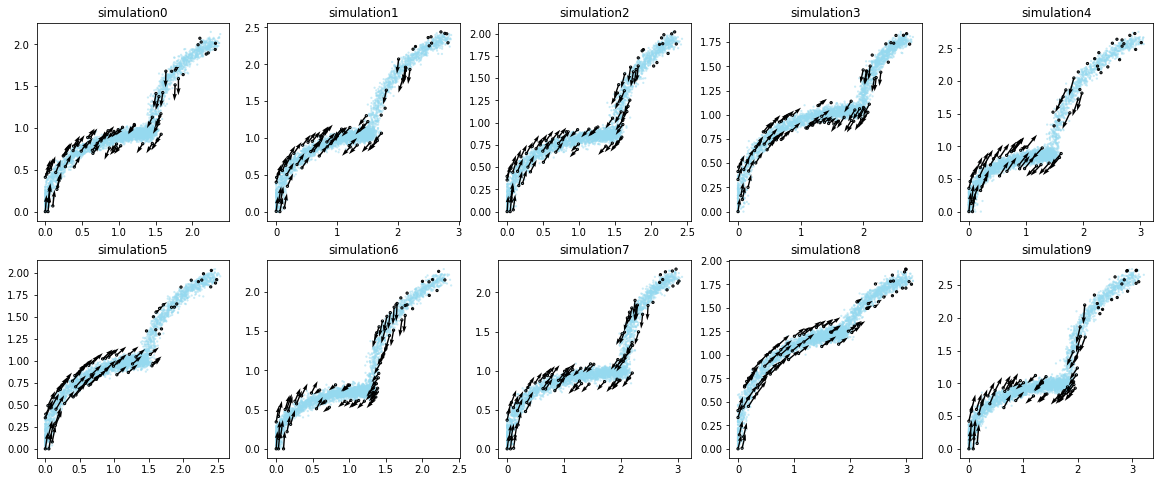

In [12]:
gene_list=list(splice_unsplice_splice_predict_unsplice_predict_dynamic.gene_name.drop_duplicates())[0:10]

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=splice_unsplice_splice_predict_unsplice_predict_dynamic,
        custom_xlim=None,
        custom_ylim=None,
        colors=None,
        alpha=0.5, 
        s = 5,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    # ax.axis('off')

plt.show()